In [88]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf 
import json
from functools import reduce
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Conv1D, Input, Concatenate, BatchNormalization, MaxPooling1D
from keras.layers.embeddings import Embedding
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [89]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [90]:
## Data
train = json.load(open('assets/train.json'))
snippets = [t['snippet'] for t in train]
tags = [t['tags'] for t in train]

### Process snippets
raw_text = "".join(snippets)
chars = sorted(list(set(raw_text)))
mapping = dict((c, i + 1) for i, c in enumerate(chars))
sequences = []
for snippet in snippets:
    encoded_seq = [mapping.get(char) for char in snippet]
    sequences.append(encoded_seq)
    
vocab_size = len(mapping) + 1
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print("Vob: %d" % vocab_size)
print("Len: %d" % max_length)
    
### Process tags
tt = reduce(lambda agg, n: agg + n, tags, [])
tt = sorted(list(set(tt)))
mapping = dict((c, i) for i, c in enumerate(tt))
labels = []

for tag in tags:
    raw_label = [0] * len(mapping)
    for t in tag:
        raw_label[mapping.get(t)] = 1
    labels.append(raw_label)
    
labels = np.array([np.array(l) for l in labels])

Vob: 405
Len: 44144


In [91]:
inputs = Input(shape=(max_length, ))

embedding = Embedding(vocab_size, 16, input_length=max_length, trainable=False)(inputs)
### CNN layers
convs = []
for n, fsz in [(128, 2), (192, 3), (256, 4), (512, 5)]:
    model = Conv1D(n, fsz, activation='relu', padding='same')(embedding)
    model = BatchNormalization()(model)
    model = Conv1D(n, fsz, activation='relu', padding='same')(model)
    model = MaxPooling1D()(model)
    convs.append(model)

model = Concatenate(axis=-1)(convs)
model = Flatten()(model)
### Fully connected layers
model = BatchNormalization()(model)
model = Dense(7, activation='relu')(model)
model = BatchNormalization()(model)
model = Dense(7, activation='relu')(model)
model = BatchNormalization()(model)

model = Dense(labels.shape[1], activation='sigmoid')(model)
model = Model(inputs, model)
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 44144)        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 44144, 16)    6480        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 44144, 128)   4224        embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 44144, 192)   9408        embedding_3[0][0]                
____________________________________________________________________________________________

In [92]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

In [ ]:
history = model.fit(padded_sequences, labels, epochs=10, verbose=True)

Epoch 1/10


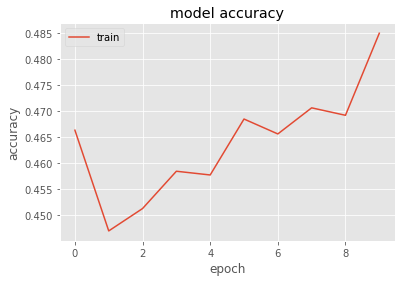

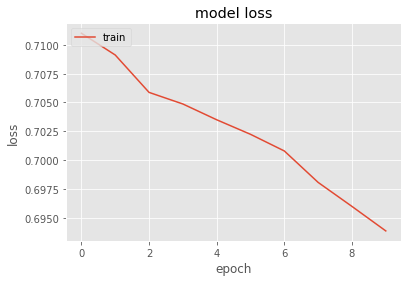

In [87]:
plot_history(history)

In [59]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])
